In [2]:
# Data Loading

import networkx as nx

# Data loading
G_caltech = nx.read_gml('fb100/data/Caltech36.gml')
G_mit = nx.read_gml('fb100/data/MIT8.gml')
G_jh = nx.read_gml('fb100/data/Johns Hopkins55.gml')



graphs = {
    "Caltech": G_caltech,
    "MIT": G_mit,
    "Johns Hopkins": G_jh
}

# Question 2: Social Network Analysis with the Facebook100 Dataset


## a- Plotting the degree destribution for Caltech, MIT and John Hopkins

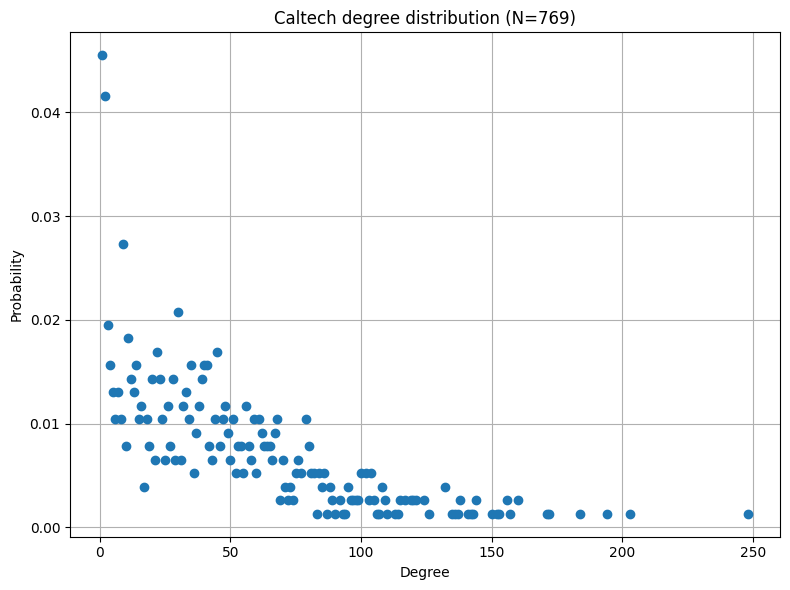

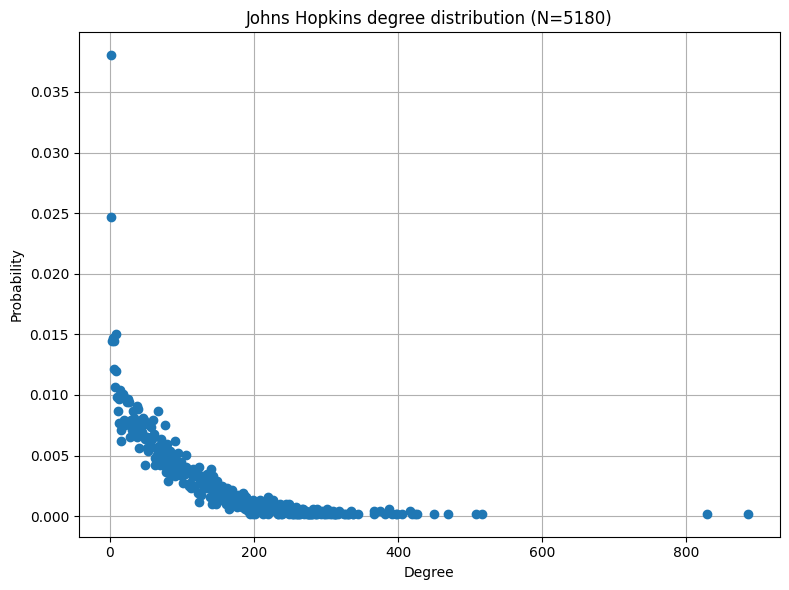

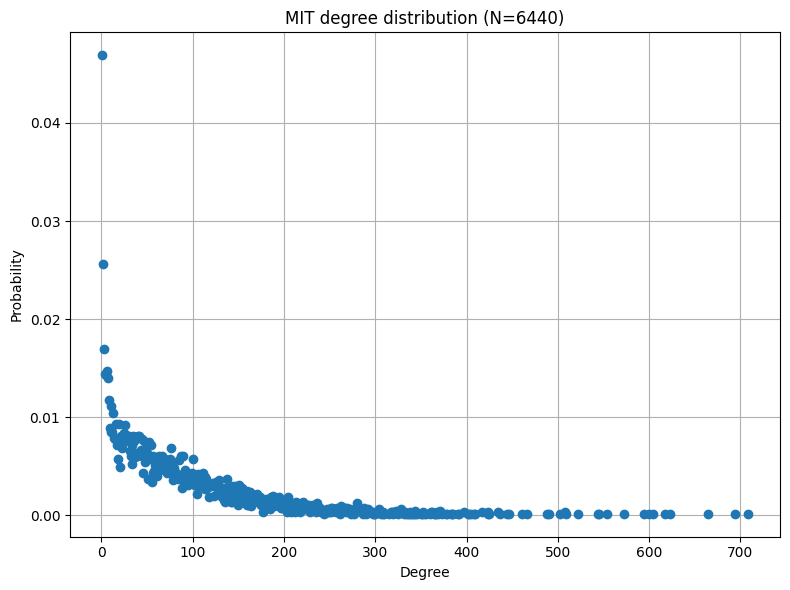

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_degree_distribution(G, name):
    plt.figure(figsize=(8, 6))

    N = G.number_of_nodes()
    degrees = [d for _, d in G.degree()]
    degree_counts = Counter(degrees)

    degree_values = sorted(degree_counts.keys())
    freq_of_degree = [degree_counts[k] / N for k in degree_values]

    plt.plot(degree_values, freq_of_degree, 'o')
    plt.title(f"{name} degree distribution (N={N})")
    plt.xlabel("Degree")
    plt.ylabel("Probability")
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    # plt.yscale('log')
    # plt.xscale('log')
    plt.show()

# Plot each network separately
plot_degree_distribution(G_caltech, "Caltech")
plot_degree_distribution(G_jh, "Johns Hopkins")
plot_degree_distribution(G_mit, "MIT")


## b- Clustering Coefficient, Edge Density, and Sparsity

In [9]:
import numpy as np

for name, G in graphs.items():
    N = G.number_of_nodes()
    M = G.number_of_edges()

    global_clustering = nx.transitivity(G)
    local_clustering_list = nx.clustering(G).values()
    mean_local_clustering = np.mean(list(local_clustering_list))
    
    max_edges = N * (N - 1) / 2
    density = M / max_edges if max_edges > 0 else 0


    print(f"\n--- {name} ---")
    print(f"Nodes (N): {N}, Edges (M): {M}")
    print(f"Global Clustering Coefficient: {global_clustering:.4f}")
    print(f"Mean Local Clustering Coefficient: {mean_local_clustering:.4f}")
    print(f"Edge Density (D): {density:.6f}")



--- Caltech ---
Nodes (N): 769, Edges (M): 16656
Global Clustering Coefficient: 0.2913
Mean Local Clustering Coefficient: 0.4093
Edge Density (D): 0.056404

--- MIT ---
Nodes (N): 6440, Edges (M): 251252
Global Clustering Coefficient: 0.1803
Mean Local Clustering Coefficient: 0.2712
Edge Density (D): 0.012118

--- Johns Hopkins ---
Nodes (N): 5180, Edges (M): 186586
Global Clustering Coefficient: 0.1932
Mean Local Clustering Coefficient: 0.2684
Edge Density (D): 0.013910


## c- Degree vs. Local Clustering Coefficient

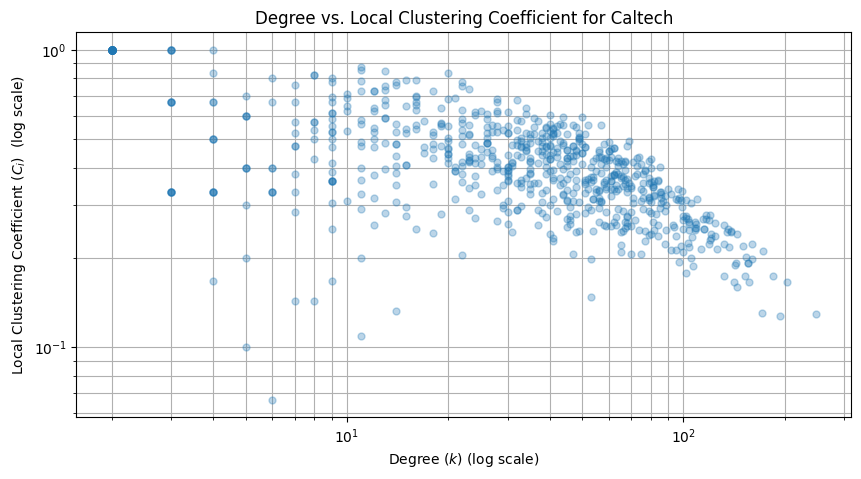

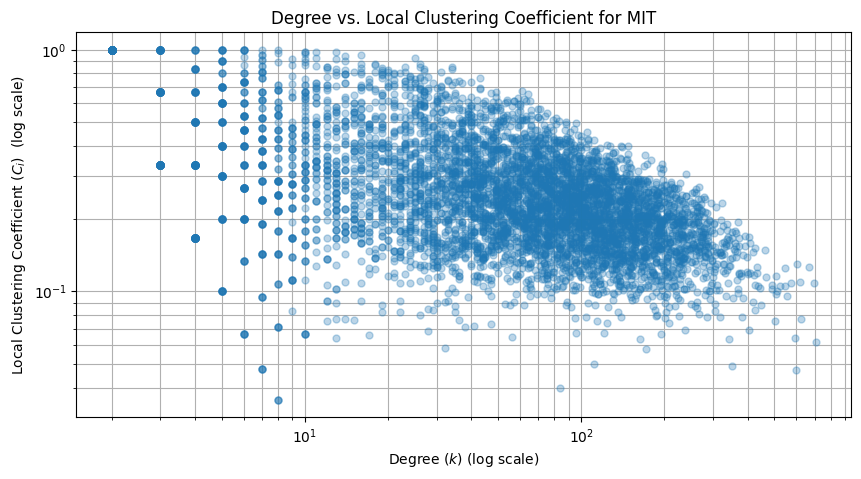

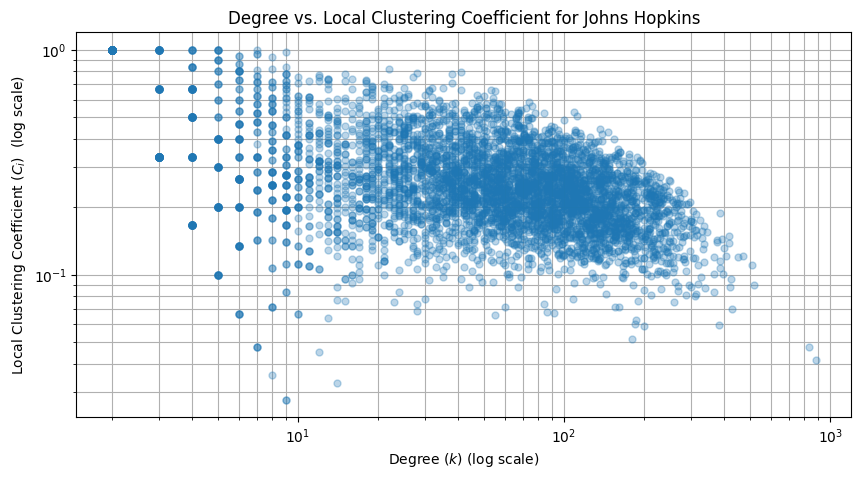

In [14]:
for name, G in graphs.items():
    N = G.number_of_nodes()
    degrees = dict(G.degree())
    local_clustering = nx.clustering(G)
    
    # Filter out nodes that are not in both dictionaries (shouldn't happen with LCC)
    # and nodes with degree 0 or clustering 0/None 
    data_points = []
    for node in G.nodes():
        deg = degrees.get(node, 0)
        clust = local_clustering.get(node, 0)
        # Filter out nodes with degree 0 (shouldn't be in LCC unless N=1) or clustering 0 
        # if we intend to use log-log plot axes for degree.
        if deg > 1 and clust > 0: 
             data_points.append((deg, clust))

        
    degrees_plot = [p[0] for p in data_points]
    clustering_plot = [p[1] for p in data_points]

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(degrees_plot, clustering_plot, 'o', alpha=0.3, markersize=5)
    

    plt.title(f"Degree vs. Local Clustering Coefficient for {name}")
    plt.xlabel("Degree ($k$) (log scale) ")
    plt.ylabel("Local Clustering Coefficient ($C_i$)  (log scale)")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.show()

# Question 3: Assortativity Analysis with the Facebook100 Dataset

### Note:
We transformed the .gml Graphs to .pkl files to optimise the time of reading/writing files.

✅ Cache file found: 'fb100_assortativity_cache.pkl'
Loading data from file...
Data loaded successfully.
Generating plots...


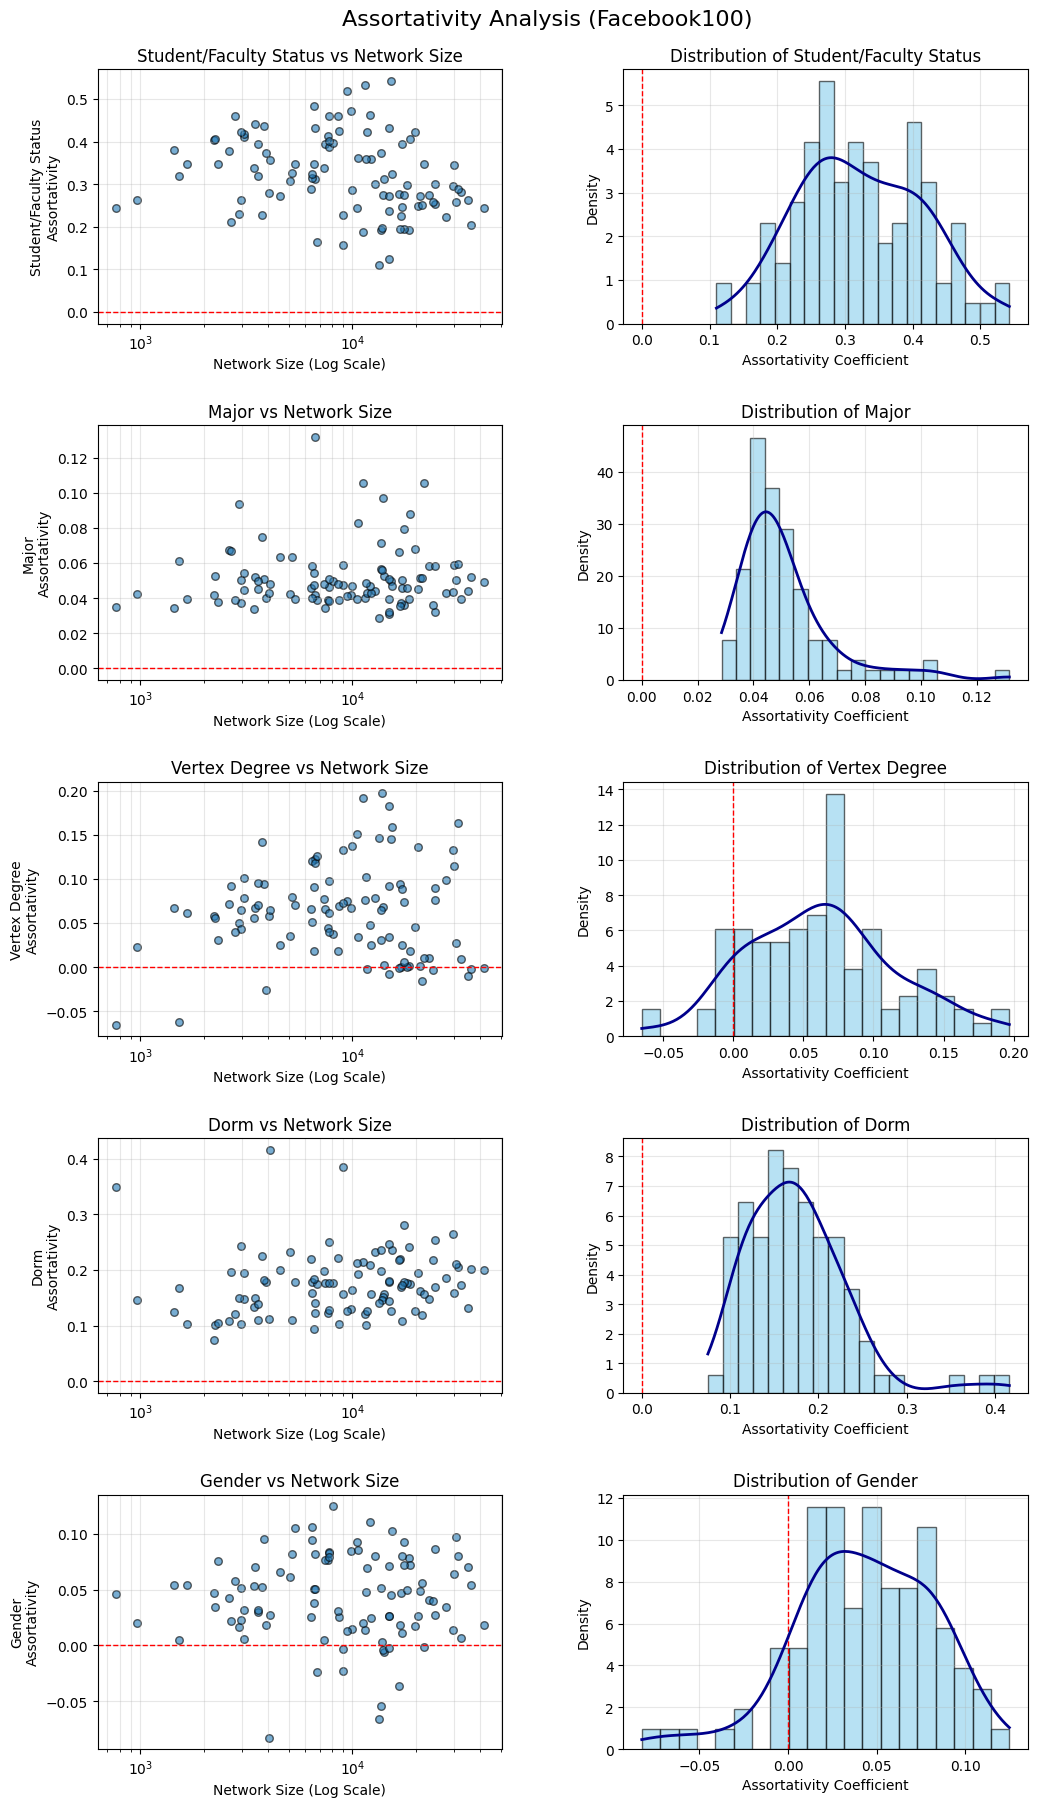

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import glob
import os
import pickle
import numpy as np
from scipy.stats import gaussian_kde

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the folder containing the 100 .pkl files
DATA_FOLDER_PATH = "pickle"  

CACHE_FILE = "fb100_assortativity_cache.pkl"



results = None

# Check if cache file exists
if os.path.exists(CACHE_FILE):
    print(f"✅ Cache file found: '{CACHE_FILE}'")
    print("Loading data from file...")
    try:
        with open(CACHE_FILE, "rb") as f:
            results = pickle.load(f)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"⚠️ Error loading cache: {e}. Recalculating from scratch.")
        results = None

# If results are still None (cache didn't exist or failed to load), calculate from scratch
if results is None:
    print(f"❌ No cache found. Processing files from '{DATA_FOLDER_PATH}'...")
    
    # Initialize structure
    results = {
        "student_fac": [],
        "major_index": [],
        "degree": [],
        "dorm": [],
        "gender": []
    }

    # Get list of .pkl files
    files = glob.glob(os.path.join(DATA_FOLDER_PATH, "*.pkl"))
    if not files:
        # Fallback check for .pickle extension
        files = glob.glob(os.path.join(DATA_FOLDER_PATH, "*.pickle"))

    if not files:
        print(f"⛔ Error: No .pkl files found in {DATA_FOLDER_PATH}")
    else:
        print(f"Found {len(files)} networks. Calculating metrics...")
        
        for i, file_path in enumerate(files):
            file_name = os.path.basename(file_path)
            
            # Optional progress indicator
            if i % 10 == 0:
                print(f"Processing {i}/{len(files)}: {file_name}...")

            try:
                with open(file_path, 'rb') as f:
                    G = pickle.load(f)
                
                N = G.number_of_nodes()
                
                # 1. Degree Assortativity
                try:
                    r_deg = nx.degree_assortativity_coefficient(G)
                    results["degree"].append((N, r_deg))
                except:
                    results["degree"].append((N, np.nan))

                # 2. Attribute Assortativity
                attributes_to_check = ["student_fac", "major_index", "dorm", "gender"]
                for attr in attributes_to_check:
                    try:
                        val = nx.attribute_assortativity_coefficient(G, attr)
                        results[attr].append((N, val))
                    except:
                        results[attr].append((N, np.nan))

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")

        # Save the calculated results to cache file
        print(f"💾 Saving results to '{CACHE_FILE}'...")
        with open(CACHE_FILE, "wb") as f:
            pickle.dump(results, f)
        print("Done.")

# ==========================================
# 3. PLOTTING
# ==========================================
if results:
    print("Generating plots...")
    
    # Mapping keys to readable titles
    plot_titles = {
        "student_fac": "Student/Faculty Status",
        "major_index": "Major",
        "degree": "Vertex Degree",
        "dorm": "Dorm",
        "gender": "Gender"
    }

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
    fig.suptitle(f"Assortativity Analysis (Facebook100)", fontsize=16)
    fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.95)

    metrics = ["student_fac", "major_index", "degree", "dorm", "gender"]

    for i, metric in enumerate(metrics):
        raw_data = results.get(metric, [])
        
        # Filter NaNs
        clean_data = [d for d in raw_data if not np.isnan(d[1])]
        
        if not clean_data:
            print(f"No valid data for {metric}")
            continue
            
        sizes = [d[0] for d in clean_data]
        coeffs = [d[1] for d in clean_data]
        title = plot_titles.get(metric, metric)

        # --- Scatter Plot ---
        ax_scatter = axes[i, 0]
        ax_scatter.scatter(sizes, coeffs, alpha=0.6, edgecolors='black', s=30)
        ax_scatter.set_xscale('log')
        ax_scatter.axhline(0, color='red', linestyle='--', linewidth=1)
        ax_scatter.set_ylabel(f"{title}\nAssortativity")
        ax_scatter.set_xlabel("Network Size (Log Scale)")
        ax_scatter.set_title(f"{title} vs Network Size")
        ax_scatter.grid(True, which="both", alpha=0.3)

        # --- Histogram / Density ---
        ax_hist = axes[i, 1]
        ax_hist.hist(coeffs, bins=20, color='skyblue', edgecolor='black', density=True, alpha=0.6)
        ax_hist.axvline(0, color='red', linestyle='--', linewidth=1)
        
        # KDE Curve
        if len(coeffs) > 1 and np.std(coeffs) > 0:
            try:
                density = gaussian_kde(coeffs)
                xs = np.linspace(min(coeffs), max(coeffs), 200)
                ax_hist.plot(xs, density(xs), color='darkblue', linewidth=2)
            except:
                pass

        ax_hist.set_ylabel("Density")
        ax_hist.set_xlabel("Assortativity Coefficient")
        ax_hist.set_title(f"Distribution of {title}")
        ax_hist.grid(True, alpha=0.3)

    plt.show()
else:
    print("No results available to plot.")

# Question 4: Link prediction

## b- Implementing the link prediction metrics: common neighbors, jaccard, Adamic/Adar

In [17]:
import networkx as nx
import math
from abc import ABC, abstractmethod
from itertools import combinations

class LinkPrediction(ABC):
    def __init__(self, graph):
        self.graph = graph
        self.N = len(graph)
        # Precompute neighbors as sets once for all child classes
        self._neighbor_sets = {
            node: set(self.neighbors(node))
            for node in self.graph.nodes()
        }

    def neighbors(self, v):
        neighbors_list = self.graph.neighbors(v)
        return list(neighbors_list)

    @abstractmethod
    def fit(self):
        raise NotImplementedError("Fit must be implemented")



class CommonNeighbors(LinkPrediction):
    def __init__(self, graph):
        super(CommonNeighbors, self).__init__(graph)

    def fit(self):

        pair_info = {}
        for u, v in combinations(self.graph.nodes(), 2):
            cn = self._neighbor_sets[u] & self._neighbor_sets[v]  # set intersection
            if cn:  # optional: skip empty intersections
                pair_info[(u, v)] = len(cn)

        # Sort by CN count descending
        pair_info_sorted = dict(
            sorted(pair_info.items(), key=lambda x: x[1], reverse=True)
        )
        return pair_info_sorted


class Jaccard(LinkPrediction):
    def __init__(self, graph):
        super(Jaccard, self).__init__(graph)

    def fit(self):

        pair_info = {}
        for u, v in combinations(self.graph.nodes(), 2):
            neighbors_u = self._neighbor_sets[u]
            neighbors_v = self._neighbor_sets[v]
            union_size = len(neighbors_u | neighbors_v)
            cn_count = len(neighbors_u & neighbors_v)
            jaccard = cn_count / union_size if union_size > 0 else 0
            if jaccard > 0:
                pair_info[(u, v)] = jaccard

        # Sort descending
        pair_info_sorted = dict(
            sorted(pair_info.items(), key=lambda x: x[1], reverse=True)
        )
        return pair_info_sorted


class AdamicAdar(LinkPrediction):
    def __init__(self, graph):
        super(AdamicAdar, self).__init__(graph)

    def fit(self):

        pair_info = {}
        for u, v in combinations(self.graph.nodes(), 2):
            common = self._neighbor_sets[u] & self._neighbor_sets[v]
            aa_score = 0
            for w in common:
                deg_w = len(self._neighbor_sets[w])
                if deg_w > 1:
                    aa_score += 1 / math.log(deg_w)
            if aa_score > 0:
                pair_info[(u, v)] = aa_score

        # Sort descending
        pair_info_sorted = dict(
            sorted(pair_info.items(), key=lambda x: x[1], reverse=True)
        )
        return pair_info_sorted


In [ ]:
# Data loading
G_caltech = nx.read_gml('fb100/data/Caltech36.gml')
cn = CommonNeighbors(G_caltech)
jc = Jaccard(G_caltech)
aa = AdamicAdar(G_caltech)
cn_score = cn.fit()
jcd_score = jc.fit()
ad_score = aa.fit()
cn_score, jcd_score, ad_score

({('423', '531'): 114,
  ('625', '708'): 103,
  ('89', '329'): 101,
  ('89', '376'): 100,
  ('256', '562'): 99,
  ('256', '630'): 99,
  ('89', '131'): 97,
  ('89', '708'): 97,
  ('187', '708'): 93,
  ('256', '462'): 93,
  ('89', '663'): 90,
  ('513', '708'): 90,
  ('89', '454'): 89,
  ('187', '625'): 89,
  ('329', '376'): 89,
  ('562', '630'): 89,
  ('589', '708'): 89,
  ('89', '278'): 88,
  ('669', '708'): 88,
  ('131', '329'): 84,
  ('462', '562'): 84,
  ('84', '625'): 83,
  ('462', '630'): 83,
  ('84', '338'): 82,
  ('131', '376'): 82,
  ('222', '622'): 82,
  ('77', '414'): 80,
  ('115', '637'): 80,
  ('151', '256'): 78,
  ('329', '663'): 78,
  ('663', '686'): 78,
  ('30', '256'): 77,
  ('84', '372'): 77,
  ('115', '372'): 77,
  ('278', '376'): 77,
  ('115', '419'): 76,
  ('131', '278'): 76,
  ('399', '708'): 76,
  ('637', '734'): 76,
  ('0', '480'): 75,
  ('629', '686'): 75,
  ('187', '513'): 74,
  ('15', '531'): 73,
  ('84', '708'): 73,
  ('131', '454'): 73,
  ('419', '734'): 73,


## c- Evaluating link predictors

In [ ]:
import pandas as pd
import random


def evaluate_link_prediction(graph, fraction, k_values):
    """
    Evaluates CN, Jaccard, and Adamic/Adar on a specific graph.
    
    Parameters:
    -----------
    graph : networkx.Graph
        The original full graph.
    fraction : float
        The fraction of edges to remove (e.g., 0.1 for 10%).
    k_values : list
        The list of k thresholds to calculate metrics for (e.g., [50, 100, 200]).
        
    Returns:
    --------
    pd.DataFrame
        A dataframe comparing the metrics for all predictors.
    """
    
    # 1. SETUP: Prepare edges
    # We need to handle node types carefully (str vs int) depending on GML loading
    all_edges = list(graph.edges())
    num_edges_to_remove = int(len(all_edges) * fraction)
    
    random.seed(42) # Fixed seed for reproducibility
    random.shuffle(all_edges)
    
    edges_removed = all_edges[:num_edges_to_remove]
    edges_remaining = all_edges[num_edges_to_remove:]
    
    removed_edges_set = set()
    for u, v in edges_removed:
        removed_edges_set.add(tuple(sorted((str(u), str(v)))))
    
    # 2. CREATE G_TRAIN
    # Create a copy of the graph and remove the edges
    G_train = graph.copy()
    G_train.remove_edges_from(edges_removed)
    
    print(f"Original Edges: {len(all_edges)}")
    print(f"Training Edges: {len(edges_remaining)}")
    print(f"Edges to Predict (Hidden): {len(edges_removed)}")
    print("-" * 30)

    # 3. INITIALIZE PREDICTORS
    # We pass G_train (the partial graph) to the algorithms
    predictors = [
        CommonNeighbors(G_train),
        Jaccard(G_train),
        AdamicAdar(G_train)
    ]
    
    results = []

    # 4. RUN EVALUATION LOOP
    for predictor in predictors:
        pred_name = predictor.__class__.__name__
        print(f"Running {pred_name}...")
        
        scores_dict = predictor.fit()
        
        valid_predictions = []
        
        for (u, v), score in scores_dict.items():
            # Ensure u, v are strings to match graph labels usually found in GML
            u_str, v_str = str(u), str(v)
            
            # Check if this edge exists in the training graph (if so, skip it)
            if not G_train.has_edge(u_str, v_str):
                valid_predictions.append(((u_str, v_str), score))
        
        # Sort again just to be safe (though fit() usually sorts)
        valid_predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Calculate Metrics for each K
        for k in k_values:
            # Take Top K pairs
            top_k_pairs = valid_predictions[:k]
            
            # Count Hits (intersection with removed set)
            hits = 0
            for (u, v), score in top_k_pairs:
                # Normalize pair to match the set format
                normalized_pair = tuple(sorted((u, v)))
                if normalized_pair in removed_edges_set:
                    hits += 1
            
            precision = hits / k
            
            # Recall = Correct Guesses / Total Hidden Edges
            recall = hits / len(removed_edges_set)
            
            results.append({
                'Algorithm': pred_name,
                'K': k,
                'Hits': hits,
                'Precision': round(precision, 4),
                'Recall': round(recall, 4)
            })

    return pd.DataFrame(results)

In [ ]:
G_caltech = nx.read_gml('fb100/data/Caltech36.gml')
fraction_to_remove = 0.01
k_values = [50]
df_results = evaluate_link_prediction(G_jh, fraction_to_remove, k_values)
print("\nEvaluation Results:")
display(df_results)

Original Edges: 186586
Training Edges: 184721
Edges to Predict (Hidden): 1865
------------------------------
Running CommonNeighbors...
Running Jaccard...
Running AdamicAdar...

Evaluation Results:


,Algorithm,K,Hits,Precision,Recall
0,CommonNeighbors,50,8,0.16,0.0043
1,Jaccard,50,1,0.02,0.0005
2,AdamicAdar,50,7,0.14,0.0038


## d- Evaluating the link prediction algorithms on a group of graphs

In [ ]:
import os
import pickle
import time
import networkx as nx
import pandas as pd
import random
from itertools import combinations
import math
from abc import ABC, abstractmethod


def evaluate_link_prediction(graph, fraction, k_values):
    """
    Evaluates CN, Jaccard, and Adamic/Adar on a specific graph
    and measures execution time.
    """

    all_edges = list(graph.edges())
    num_edges_to_remove = int(len(all_edges) * fraction)
    
    random.seed(42) 
    random.shuffle(all_edges)
    
    edges_removed = all_edges[:num_edges_to_remove]
    
    # Create Set for O(1) lookup
    removed_edges_set = set()
    for u, v in edges_removed:
        removed_edges_set.add(tuple(sorted((str(u), str(v)))))
    
    # 2. CREATE G_TRAIN
    G_train = graph.copy()
    G_train.remove_edges_from(edges_removed)
    
    # 3. INITIALIZE PREDICTORS
    predictors = [
        CommonNeighbors(G_train),
        Jaccard(G_train),
        AdamicAdar(G_train)
    ]
    
    results = []

    # 4. RUN EVALUATION LOOP
    for predictor in predictors:
        pred_name = predictor.__class__.__name__
        
        start_time = time.time()
        scores_dict = predictor.fit()
        
        end_time = time.time()
        exec_time = end_time - start_time
        

        valid_predictions = []
        for (u, v), score in scores_dict.items():
            u_str, v_str = str(u), str(v)
            if not G_train.has_edge(u_str, v_str):
                valid_predictions.append(((u_str, v_str), score))
        
        valid_predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Calculate Metrics for each K
        for k in k_values:
            top_k_pairs = valid_predictions[:k]
            
            hits = 0
            for (u, v), score in top_k_pairs:
                normalized_pair = tuple(sorted((u, v)))
                if normalized_pair in removed_edges_set:
                    hits += 1
            
            precision = hits / k
            recall = hits / len(removed_edges_set)
            
            results.append({
                'Algorithm': pred_name,
                'K': k,
                'Precision': precision,
                'Recall': recall,
                'Execution_Time': exec_time
            })

    return pd.DataFrame(results)

def run_specific_graphs_evaluation(folder_path, graph_list, fraction=0.1, k=50):
    """
    Evaluates specific graphs provided in a list.
    """
    
    print(f"Starting evaluation on {len(graph_list)} specific graphs...")
    print(f"Fraction: {fraction}, Top-K: {k}")
    print("=" * 60)

    all_results = []
    
    for i, graph_name in enumerate(graph_list):
        # Construct the full path: Folder + Name + .pkl
        filename = f"{graph_name}.pkl"
        file_path = os.path.join(folder_path, filename)
        
        print(f"[{i+1}/{len(graph_list)}] Processing: {graph_name}...", end=" ")
        
        if not os.path.exists(file_path):
            print(f"\n   Error: File not found at {file_path}")
            continue
            
        try:
            # Load from Pickle
            with open(file_path, "rb") as f:
                G = pickle.load(f)
            
            # Extract Graph if wrapped in dict/tuple
            if not isinstance(G, (nx.Graph, nx.DiGraph)):
                 if isinstance(G, dict) and 'graph' in G:
                    G = G['graph']
            
            # Run Evaluation
            df_result = evaluate_link_prediction(G, fraction, [k])
            df_result['Graph_Name'] = graph_name
            all_results.append(df_result)
            
            print("Done.")
            
        except Exception as e:
            print(f"\n   Error processing {graph_name}: {e}")

    if not all_results:
        return None, None

    final_df = pd.concat(all_results, ignore_index=True)

    # Aggregation: Group by Algorithm
    summary_df = final_df.groupby('Algorithm')[['Precision', 'Execution_Time']].agg(['mean', 'std']).reset_index()
    summary_df.columns = ['Algorithm', 'Mean_Precision', 'Std_Precision', 'Mean_Time (s)', 'Std_Time']

    return final_df, summary_df


dataset_folder = 'pickle'
target_graphs = ['Caltech36', 'Reed98', 'Simmons81', 'Haverford76', 'Swarthmore42',
    'USFCA72', 'Bowdoin47', 'Amherst41', 'Mich67', 'Oberlin44', 'Hamilton46']

full_results, mean_summary = run_specific_graphs_evaluation(
    folder_path=dataset_folder, 
    graph_list=target_graphs,
    fraction=0.1, 
    k=50
)

Starting evaluation on 11 specific graphs...
Fraction: 0.1, Top-K: 50
[1/11] Processing: Caltech36... Done.
[2/11] Processing: Reed98... Done.
[3/11] Processing: Simmons81... Done.
[4/11] Processing: Haverford76... Done.
[5/11] Processing: Swarthmore42... Done.
[6/11] Processing: USFCA72... Done.
[7/11] Processing: Bowdoin47... Done.
[8/11] Processing: Amherst41... Done.
[9/11] Processing: Mich67... Done.
[10/11] Processing: Oberlin44... Done.
[11/11] Processing: Hamilton46... Done.


In [30]:
print("\n" + "="*50)
print("FINAL RESULTS (Top @ 50)")
print("="*50)
pd.options.display.float_format = '{:,.4f}'.format
display(mean_summary)

print("\nDetailed Precision per Graph:")
display(full_results.pivot(index='Graph_Name', columns='Algorithm', values='Precision'))

print("\nDetailed Execution Time (s) per Graph:")
display(full_results.pivot(index='Graph_Name', columns='Algorithm', values='Execution_Time'))


FINAL RESULTS (Top @ 50)


,Algorithm,Mean_Precision,Std_Precision,Mean_Time (s),Std_Time
0,AdamicAdar,0.6455,0.1085,9.1506,5.4645
1,CommonNeighbors,0.6418,0.1022,5.1392,3.1597
2,Jaccard,0.4745,0.1635,15.6486,10.0797



Detailed Precision per Graph:


Algorithm,AdamicAdar,CommonNeighbors,Jaccard
Graph_Name,,,
Amherst41,0.8200,0.7800,0.7200
Bowdoin47,0.6000,0.6400,0.5000
Caltech36,0.7400,0.7200,0.3600
Hamilton46,0.6200,0.6000,0.6600
Haverford76,0.7600,0.7600,0.5200
Mich67,0.6000,0.5800,0.3600
Oberlin44,0.6200,0.6400,0.3800
Reed98,0.5000,0.5000,0.2600
Simmons81,0.7000,0.7200,0.2800



Detailed Execution Time (s) per Graph:


Algorithm,AdamicAdar,CommonNeighbors,Jaccard
Graph_Name,,,
Amherst41,10.2612,5.5695,18.5556
Bowdoin47,9.7842,8.4752,18.5973
Caltech36,1.0162,0.5352,1.4901
Hamilton46,13.6722,9.0265,27.2661
Haverford76,7.8209,3.3742,10.2148
Mich67,15.0485,7.9573,29.1047
Oberlin44,17.7535,8.5602,26.9343
Reed98,1.5496,0.7892,1.9720
Simmons81,4.3066,1.9858,6.1518


# Question 5: Label Propagation

## b- Implementing the label propagation algorithm

In [31]:
import networkx as nx
import numpy as np
import torch
import pickle
import scipy.sparse as sp
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error

def load_graph(file_path):
    try:
        with open(file_path, 'rb') as f:
            G = pickle.load(f)
    except:
        G = nx.read_gpickle(file_path)
    return G


class LabelPropagation(torch.nn.Module):
    def __init__(self, adj_matrix, labels, mask_indices, num_classes):
        super(LabelPropagation, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 1. Transition Matrix P = D^-1 * A
        degrees = np.array(adj_matrix.sum(axis=1)).flatten()
        degrees[degrees == 0] = 1.0
        D_inv = sp.diags(1.0 / degrees)
        P = D_inv.dot(adj_matrix).tocoo()
        
        # Convert to PyTorch Sparse Tensor
        indices = torch.from_numpy(np.vstack((P.row, P.col)).astype(np.int64))
        values = torch.from_numpy(P.data.astype(np.float32))
        shape = torch.Size(P.shape)
        self.P = torch.sparse_coo_tensor(indices, values, shape).to(self.device)
        
        # 2. Label Matrix Y
        self.num_nodes = adj_matrix.shape[0]
        self.Y = torch.zeros((self.num_nodes, num_classes), dtype=torch.float32).to(self.device)
        
        # One-hot encode known labels
        labels_tensor = torch.tensor(labels, dtype=torch.long).to(self.device)
        y_onehot = torch.nn.functional.one_hot(labels_tensor, num_classes).float()
        
        # 3. Handle Masking (Keep mask vs Hidden mask)
        is_hidden = torch.zeros(self.num_nodes, dtype=torch.bool).to(self.device)
        if len(mask_indices) > 0:
            is_hidden[mask_indices] = True
        
        self.keep_mask = ~is_hidden # Boolean: True for nodes we KEEP (Clamping targets)
        
        # Initialize: Set kept nodes to their one-hot values, hidden to 0
        self.Y[self.keep_mask] = y_onehot[self.keep_mask]
        
        # Save static copy for the Clamping step
        self.Y_static = self.Y.clone()

    def forward(self, max_iter=100, tol=1e-3):
        for i in range(max_iter):
            Y_prev = self.Y.clone()
            
            # Propagate: Y = P * Y
            self.Y = torch.sparse.mm(self.P, self.Y)
            
            # Clamp: Reset known nodes
            self.Y[self.keep_mask] = self.Y_static[self.keep_mask]
            
            # Check convergence
            if torch.norm(self.Y - Y_prev, p=1) < tol:
                break
        return self.Y

# --- Main Function ---
def run_label_propagation(graph_file, attribute, fraction_removed, metrics=['accuracy']):
    """
    Args:
        graph_file (str): Path to .pkl file
        attribute (str): 'dorm', 'year', 'major_index', etc.
        fraction_removed (float): 0.1, 0.2, etc.
        metrics (list): List of metrics to return: ['accuracy', 'mse', 'mae', 'f1', 'all']
    """
    
    # 1. Load Data
    print(f"Loading {graph_file}...")
    G = load_graph(graph_file)
    nodes = list(G.nodes())
    adj = nx.adjacency_matrix(G)
    
    # 2. Extract and Filter Attribute
    raw_labels = []
    valid_node_indices = []
    
    for i, n in enumerate(nodes):
        val = G.nodes[n].get(attribute, 0)
        # 0 usually implies missing in FB100
        if val != 0:
            valid_node_indices.append(i)
            raw_labels.append(val)
            
    if not valid_node_indices:
        return {"error": f"No valid labels for {attribute}"}

    # Map labels to 0..K-1 range
    unique_classes = sorted(list(set(raw_labels)))
    class_map = {val: i for i, val in enumerate(unique_classes)}
    inverse_map = {i: val for i, val in enumerate(unique_classes)} # To get original values back
    
    mapped_labels = np.array([class_map[v] for v in raw_labels])
    num_classes = len(unique_classes)
    
    # Fill full label array (put 0 for nodes that were originally missing)
    full_labels_mapped = np.zeros(len(nodes), dtype=int)
    full_labels_mapped[valid_node_indices] = mapped_labels
    
    # 3. Create Mask (Remove Fraction)
    num_valid = len(valid_node_indices)
    num_remove = int(num_valid * fraction_removed)
    
    perm = np.random.permutation(num_valid)
    indices_to_hide_local = perm[:num_remove]
    
    # Convert local valid indices to global graph indices
    global_hide_indices = np.array(valid_node_indices)[indices_to_hide_local]
    
    # Mask passed to model = (Nodes we just hid) + (Nodes originally missing)
    all_indices = np.arange(len(nodes))
    global_valid_set = set(valid_node_indices)
    original_missing = [ix for ix in all_indices if ix not in global_valid_set]
    final_mask = np.concatenate((global_hide_indices, original_missing)).astype(int)
    
    # 4. Run Model
    model = LabelPropagation(adj, full_labels_mapped, final_mask, num_classes)
    final_Y = model.forward()
    
    # 5. Get Predictions
    final_probs = final_Y.cpu().numpy()
    pred_indices = np.argmax(final_probs, axis=1)
    
    # 6. Evaluation (Only on the nodes we artificially hid)
    # Get Mapped Predictions (0..K)
    y_pred_mapped = pred_indices[global_hide_indices]
    y_true_mapped = full_labels_mapped[global_hide_indices]
    
    # Convert back to Original Values (e.g., Year 2004, 2005) for meaningful MAE/MSE
    y_pred_original = np.array([inverse_map[i] for i in y_pred_mapped])
    y_true_original = np.array([inverse_map[i] for i in y_true_mapped])
    
    # 7. Calculate Metrics
    results = {}
    
    if 'all' in metrics:
        metrics = ['accuracy', 'mse', 'mae', 'f1']

    if 'accuracy' in metrics:
        results['accuracy'] = accuracy_score(y_true_original, y_pred_original)
        
    if 'f1' in metrics:
        # Weighted handles class imbalance better
        results['f1'] = f1_score(y_true_original, y_pred_original, average='weighted')
        
    if 'mae' in metrics:
        # Meaningful for 'year', less so for 'major', but requested by homework
        results['mae'] = mean_absolute_error(y_true_original, y_pred_original)
        
    if 'mse' in metrics:
        results['mse'] = mean_squared_error(y_true_original, y_pred_original)

    # Print Report
    print(f"\n--- Results for {attribute} (Removed: {fraction_removed}) ---")
    for k, v in results.items():
        print(f"{k.upper()}: {v:.4f}")
        
    return results


## c- Performing the label propagation algorithm for the Johns Hopkins graph

In [34]:
file = 'pickle/Johns Hopkins55.pkl' 
metrics_to_use = ['accuracy', 'mae', 'f1'] 

# Example for Year (where MAE makes sense)
res_year = run_label_propagation(file, 'dorm', 0.3, metrics='accuracy')

# Example for Major (where Accuracy/F1 make sense)
res_major = run_label_propagation(file, 'year', 0.3, metrics=['accuracy'])

Loading pickle/Johns Hopkins55.pkl...

--- Results for dorm (Removed: 0.3) ---
ACCURACY: 0.3600
Loading pickle/Johns Hopkins55.pkl...

--- Results for year (Removed: 0.3) ---
ACCURACY: 0.8423


In [37]:
file_path = 'pickle/Duke14.pkl'
attributes = ['major_index', 'dorm', 'year', 'gender'] 
fractions = [0.1, 0.2, 0.3]

# Dictionary to hold the data for the dataframe
# Structure: {'Attribute': {'0.1': val, '0.2': val, ...}}
table_data = {}

print(f"Starting experiments on {file_path}...")

for attr in attributes:
    # Clean up the name for the table (e.g., 'major_index' -> 'Major')
    display_name = attr.replace('_index', '').capitalize()
    table_data[display_name] = {}
    
    for frac in fractions:
        # We request multiple metrics, but we will extract Accuracy for the table 
        # to match the Table 1 format in the homework.
        try:
            # --- Calling the function directly as requested ---
            res = run_label_propagation(
                graph_file=file_path, 
                attribute=attr, 
                fraction_removed=frac, 
                metrics=['f1'] 
            )
            
            # Check if the function returned an error (e.g., attribute missing)
            if 'error' in res:
                print(f"Skipping {attr}: {res['error']}")
                table_data[display_name][frac] = np.nan
            else:
                # Store Accuracy in the table
                table_data[display_name][frac] = res['f1']
                
        except Exception as e:
            print(f"Error processing {attr} at {frac}: {e}")
            table_data[display_name][frac] = np.nan

# Create and Format the DataFrame
df_results = pd.DataFrame(table_data).T  # Transpose so Attributes are Rows
df_results.columns = [f"{f}" for f in fractions] # Rename cols to 0.1, 0.2...
df_results.index.name = "Attribute"

print("\n" + "="*50)
print(f"Table 1: Accuracy of the label propagation algorithm")
print("="*50)
print(df_results.round(4))
print("="*50)

Starting experiments on pickle/Duke14.pkl...
Loading pickle/Duke14.pkl...

--- Results for major_index (Removed: 0.1) ---
F1: 0.2462
Loading pickle/Duke14.pkl...

--- Results for major_index (Removed: 0.2) ---
F1: 0.1916
Loading pickle/Duke14.pkl...

--- Results for major_index (Removed: 0.3) ---
F1: 0.2231
Loading pickle/Duke14.pkl...

--- Results for dorm (Removed: 0.1) ---
F1: 0.4983
Loading pickle/Duke14.pkl...

--- Results for dorm (Removed: 0.2) ---
F1: 0.4938
Loading pickle/Duke14.pkl...

--- Results for dorm (Removed: 0.3) ---
F1: 0.4896
Loading pickle/Duke14.pkl...

--- Results for year (Removed: 0.1) ---
F1: 0.9097
Loading pickle/Duke14.pkl...

--- Results for year (Removed: 0.2) ---
F1: 0.9020
Loading pickle/Duke14.pkl...

--- Results for year (Removed: 0.3) ---
F1: 0.8785
Loading pickle/Duke14.pkl...

--- Results for gender (Removed: 0.1) ---
F1: 0.6581
Loading pickle/Duke14.pkl...

--- Results for gender (Removed: 0.2) ---
F1: 0.6766
Loading pickle/Duke14.pkl...

--- Resul

# Question 6: Community detection


## Community detection algorithms - Louvain and Clauset-Newman-Moore greedy modularity maximization

In [40]:
import networkx as nx
import community.community_louvain as community_louvain # from python-louvain
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import sys
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def evaluate_louvain(file_path, attribute_name):
    """
    Runs Louvain community detection and compares it against a target attribute.
    
    Args:
        file_path (str): Path to the .gml file (e.g., 'Caltech36.gml')
        attribute_name (str): The node attribute to compare (e.g., 'dorm', 'year', 'major_index')
        
    Returns:
        None (Prints results)
    """
    print(f"--- Processing {file_path} for attribute: '{attribute_name}' ---")
    
    # 1. Load the Graph
    try:
        # destringizer=int converts node IDs "0", "1" to integers 0, 1
        G = nx.read_gml(file_path, destringizer=int)
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return

    # 2. Run Louvain Algorithm
    # Returns a dictionary {node_id: community_id}
    # random_state ensures reproducibility
    partition = community_louvain.best_partition(G, random_state=42)
    
    # 3. Align Prediction with Ground Truth
    y_pred = [] # The community ID found by Louvain
    y_true = [] # The actual label (e.g., Dorm ID)
    
    missing_count = 0
    
    for node in G.nodes():
        # Get the ground truth value
        # We use .get() to avoid errors if a node lacks the attribute
        true_label = G.nodes[node].get(attribute_name, 0)
        
        # 4. Data Cleaning
        # In FB100, '0' usually means missing data. 
        # We must exclude these nodes to get a fair score.
        if true_label != 0:
            y_true.append(true_label)
            y_pred.append(partition[node])
        else:
            missing_count += 1

    # 5. Calculate Metrics
    if len(y_true) == 0:
        print("Error: No valid ground truth labels found (all are 0 or missing).")
        return

    # ARI: Measures agreement (0 = random, 1 = perfect match)
    ari = adjusted_rand_score(y_true, y_pred)
    
    # NMI: Measures shared information (0 = no mutual info, 1 = perfect correlation)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    print(f"Total Nodes: {len(G.nodes())}")
    print(f"Nodes used for eval (non-missing data): {len(y_true)}")
    print(f"Detected Communities: {len(set(partition.values()))}")
    print(f"Ground Truth Classes: {len(set(y_true))}")
    print("-" * 30)
    print(f"Adjusted Rand Index (ARI):        {ari:.4f}")
    print(f"Normalized Mutual Info (NMI):     {nmi:.4f}")
    print("=" * 30 + "\n")



def evaluate_greedy_modularity(file_path, attribute_name):
    """
    Runs Clauset-Newman-Moore greedy modularity maximization and compares 
    it against a target attribute.
    """
    print(f"--- [CNM Greedy] Processing {file_path} for attribute: '{attribute_name}' ---")
    
    # 1. Load the Graph
    try:
        G = nx.read_gml(file_path, destringizer=int)
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return

    # 2. Run Greedy Modularity Algorithm
    # This is built-in to NetworkX.
    # It returns a list of frozensets, e.g., [ {1,2,3}, {4,5} ]
    print("Running algorithm... (this may take a moment for larger graphs)")
    community_sets = list(greedy_modularity_communities(G))
    
    # 3. Convert Sets to a Partition Dictionary
    # We need to map Node_ID -> Community_ID for comparison
    partition = {}
    for cid, comm_set in enumerate(community_sets):
        for node in comm_set:
            partition[node] = cid

    # 4. Align Prediction with Ground Truth
    y_pred = [] # The community ID found by CNM
    y_true = [] # The actual label (e.g., Dorm ID)
    
    # Track statistics about the ground truth
    ground_truth_labels = set()

    for node in G.nodes():
        # Get ground truth attribute
        true_label = G.nodes[node].get(attribute_name, 0)
        
        # Data Cleaning: Filter out missing data (0)
        if true_label != 0:
            y_true.append(true_label)
            y_pred.append(partition[node])
            ground_truth_labels.add(true_label)

    # 5. Calculate Metrics
    if len(y_true) == 0:
        print("Error: No valid ground truth labels found.")
        return

    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    print(f"Total Nodes: {len(G.nodes())}")
    print(f"Nodes used for eval: {len(y_true)}")
    print(f"Detected Communities: {len(community_sets)}")
    print(f"Ground Truth Classes: {len(ground_truth_labels)}")
    print("-" * 30)
    print(f"Adjusted Rand Index (ARI):        {ari:.4f}")
    print(f"Normalized Mutual Info (NMI):     {nmi:.4f}")
    print("=" * 30 + "\n")


## Louvain community detection on a large vs small network

In [ ]:

evaluate_louvain("fb100/data/Caltech36.gml", "dorm")
evaluate_louvain("fb100/data/Caltech36.gml", "year")

# Example 2: Large University (Hypothesis: Year should be higher than Dorm)
# If you have Princeton, UNC, or Georgetown, use those
evaluate_louvain("fb100/data/MIT8.gml", "dorm")
evaluate_louvain("fb100/data/MIT8.gml", "year")

--- Processing D:\Python Projects\Graph learning\fb100\data\Caltech36.gml for attribute: 'dorm' ---
Total Nodes: 769
Nodes used for eval (non-missing data): 597
Detected Communities: 11
Ground Truth Classes: 8
------------------------------
Adjusted Rand Index (ARI):        0.6763
Normalized Mutual Info (NMI):     0.6846

--- Processing D:\Python Projects\Graph learning\fb100\data\Caltech36.gml for attribute: 'year' ---
Total Nodes: 769
Nodes used for eval (non-missing data): 655
Detected Communities: 11
Ground Truth Classes: 17
------------------------------
Adjusted Rand Index (ARI):        0.0123
Normalized Mutual Info (NMI):     0.0961

--- Processing D:\Python Projects\Graph learning\fb100\data\MIT8.gml for attribute: 'dorm' ---
Total Nodes: 6440
Nodes used for eval (non-missing data): 4899
Detected Communities: 30
Ground Truth Classes: 63
------------------------------
Adjusted Rand Index (ARI):        0.0762
Normalized Mutual Info (NMI):     0.3036

--- Processing D:\Python Proj

## Clauset-Newman-Moore greedy modularity maximization on a large vs small network

In [ ]:
evaluate_greedy_modularity("fb100/data/Caltech36.gml", "dorm")
evaluate_greedy_modularity("fb100/data/Caltech36.gml", "year")

# Test on Large Graph 
evaluate_greedy_modularity("fb100/data/MIT8.gml", "dorm")
evaluate_greedy_modularity("fb100/data/MIT8.gml", "year")

--- [CNM Greedy] Processing D:\Python Projects\Graph learning\fb100\data\Caltech36.gml for attribute: 'dorm' ---
Running algorithm... (this may take a moment for larger graphs)
Total Nodes: 769
Nodes used for eval: 597
Detected Communities: 11
Ground Truth Classes: 8
------------------------------
Adjusted Rand Index (ARI):        0.2720
Normalized Mutual Info (NMI):     0.4121

--- [CNM Greedy] Processing D:\Python Projects\Graph learning\fb100\data\Caltech36.gml for attribute: 'year' ---
Running algorithm... (this may take a moment for larger graphs)
Total Nodes: 769
Nodes used for eval: 655
Detected Communities: 11
Ground Truth Classes: 17
------------------------------
Adjusted Rand Index (ARI):        0.0245
Normalized Mutual Info (NMI):     0.1057

--- [CNM Greedy] Processing D:\Python Projects\Graph learning\fb100\data\MIT8.gml for attribute: 'dorm' ---
Running algorithm... (this may take a moment for larger graphs)
Total Nodes: 6440
Nodes used for eval: 4899
Detected Communitie